# Preliminaries

In [60]:
import os
import random
from io import StringIO

import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator

from tqdm import tqdm

In [61]:
random.seed(0)
np.random.seed(0)

In [62]:
with open("function_words/oshea.txt") as f:
    lines = f.readlines()
    function_words = [line.split()[0] for line in lines]

In [63]:
HUMAN = "human"

GEMINI_10 = "gemini-1.0-pro"
GEMINI_15 = "gemini-1.5-pro-latest"

CLAUDE_SONNET = "claude-3-sonnet-20240229"
CLAUDE_OPUS = "claude-3-opus-20240229"

GPT_35 = "gpt-3.5-turbo-0125"
GPT_40 = "gpt-4-turbo-2024-04-09"

LLMS = [GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]
AUTHORS = [HUMAN] + LLMS

REDDIT = "reddit"
HEWLETT = "hewlett"
DATASETS = [REDDIT, HEWLETT]

PAIRS = []
for i, author1 in enumerate(AUTHORS):
    for author2 in AUTHORS[i + 1 :]:
        PAIRS.append((author1, author2))

In [64]:
df = []
for dataset in DATASETS:
    for author in AUTHORS:
        df_cur = pd.read_csv(f"{dataset}/responses/{author}.csv")
        df_cur["dataset"] = dataset
        df_cur["author"] = author
        df.append(df_cur)
df = pd.concat(df, ignore_index=True)

In [65]:
class ZScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, function_words):
        self.function_words = function_words
        self.vectorizer = TfidfVectorizer(
            use_idf=False, norm=None, tokenizer=word_tokenize, token_pattern=None
        )
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Fit the vectorizer to the corpus
        word_counts = self.vectorizer.fit_transform(X).toarray()

        # Save the function words and their indices if they are in the vocabulary
        self.used_function_words = [
            word for word in self.function_words if word in self.vectorizer.vocabulary_
        ]
        self.used_function_words_indices = [
            self.vectorizer.vocabulary_[word] for word in self.used_function_words
        ]

        # Fit z-score scaler to the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)
        self.scaler.fit(relative_freqs)
        return self

    def transform(self, X):
        # Transform the corpus into word counts
        word_counts = self.vectorizer.transform(X).toarray()

        # Calculate the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)

        # Calculate the z-scores
        z_scores = self.scaler.transform(relative_freqs)[
            :, self.used_function_words_indices
        ]

        return z_scores

    def get_used_function_words(self):
        return self.used_function_words

# Visualization

In [66]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

for reducer, reducer_name in [(PCA, "PCA"), (TSNE, "t-SNE")]:
    for author1, author2 in PAIRS:
        filename = f"figures/pairwise/{reducer_name}/{author1}_{author2}.png"
        if os.path.exists(filename):
            continue

        df_sampled = (
            df[(df["author"] == author1) | (df["author"] == author2)]
            .groupby(["dataset", "author", "prompt_id"])
            .apply(lambda x: x.sample(10), include_groups=False)
            .reset_index(drop=False)
        )

        z_scores_transformer = ZScoreTransformer(function_words)
        z_scores = z_scores_transformer.fit_transform(df_sampled["text"])

        dim_reducer = reducer(n_components=2)
        z_scores_reduced = dim_reducer.fit_transform(z_scores)

        df_reduced = pd.DataFrame(
            z_scores_reduced, columns=[f"{reducer_name} 1", f"{reducer_name} 2"]
        )
        df_reduced["author"] = df_sampled["author"]

        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=df_reduced, x=f"{reducer_name} 1", y=f"{reducer_name} 2", hue="author"
        )
        plt.title(f"{reducer_name} over function word embeddings")
        plt.legend(title="Author")
        plt.savefig(filename)
        plt.close()

# Classification

## Pipeline

In [67]:
def classify(df, authors, function_words, return_df_coefs=False):
    df = df[df["author"].isin(authors)]

    # n_responses_per_author_per_prompt_per_dataset = 10
    # df = df.groupby(["author", "prompt_id", "dataset"]).sample(
    #     n_responses_per_author_per_prompt_per_dataset
    # )

    # Train-test split: 12/4 (2 prompts from each dataset in the test set)
    test_indices = []
    for dataset in DATASETS:
        test_prompts = np.random.choice(8, 2, replace=False)
        test_indices.append(
            (df["dataset"] == dataset) & (df["prompt_id"].isin(test_prompts))
        )
    test_indices = pd.concat(test_indices, axis=1).any(axis=1)

    df_test = df[test_indices].copy()
    df_train = df[~test_indices].copy()

    # Set up 6-fold cross-validation
    train_indices_by_prompt = list(
        df_train.groupby(["dataset", "prompt_id"]).indices.values()
    )

    cv_iterable = []
    for _ in range(6):
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))
        # Cycle indices list
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )

    # Use the ZScoreTransformer to get the z-scores
    z_scores_transformer = ZScoreTransformer(function_words)
    z_scores_train = z_scores_transformer.fit_transform(df_train["text"])
    z_scores_test = z_scores_transformer.transform(df_test["text"])

    param_grid = {
        "C": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0],
        "solver": ["lbfgs", "liblinear"],
    }

    model = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid=param_grid,
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    # Model training and prediction
    model.fit(z_scores_train, df_train["author"])
    df_test["author_pred"] = model.predict(z_scores_test)

    if not return_df_coefs:
        return df_test

    # Logistic regression model coefficients
    coefs = model.best_estimator_.coef_.squeeze()
    used_function_words = z_scores_transformer.get_used_function_words()
    df_coefs = pd.DataFrame({"word": used_function_words, "coef": coefs})
    return df_test, df_coefs

## Binary (all 21 pairs)

In [68]:
import os
import pandas as pd
from itertools import product
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

N_TRIALS = 30


def process_pair(pair_trial):
    (author1, author2), trial = pair_trial
    df_test = classify(
        df=df,
        authors=[author1, author2],
        function_words=function_words,
    )
    accuracy = sum(df_test["author"] == df_test["author_pred"]) / len(df_test)
    return {
        "author1": author1,
        "author2": author2,
        "trial": trial,
        "accuracy": accuracy,
    }


results_filename = "classification_results/pairwise.csv"
if not os.path.exists(results_filename):
    # Run in parallel using joblib
    pairs_trials = list(product(PAIRS, range(N_TRIALS)))
    results = Parallel(n_jobs=-1)(
        delayed(process_pair)(pair_trial) for pair_trial in tqdm(pairs_trials)
    )

    # Save results
    df_results = pd.DataFrame(results)
    df_results.to_csv(results_filename, index=False)

    df_results = pd.read_csv(results_filename)

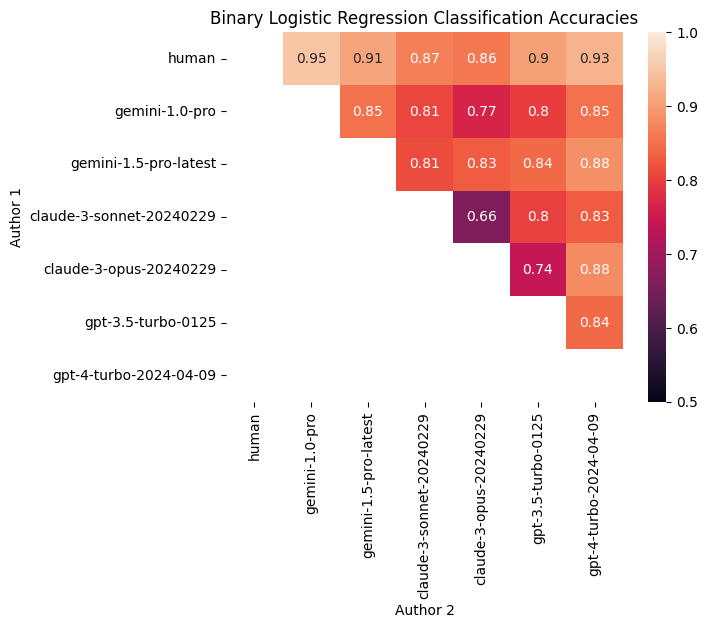

In [69]:
# Create heatmap
pivot = (
    df_results.groupby(["author1", "author2"])
    .mean()
    .reset_index()
    .pivot(index="author1", columns="author2", values="accuracy")
    .reindex(index=AUTHORS, columns=AUTHORS)
)

fig = plt.figure()
sns.heatmap(pivot, annot=True, vmin=0.5, vmax=1.0)
plt.title("Binary Logistic Regression Classification Accuracies")
plt.ylabel("Author 1")
plt.xlabel("Author 2")
figure_filename = "figures/pairwise/classification/heatmap.png"
plt.savefig(figure_filename, bbox_inches="tight")